In [1]:
import gym
import numpy as np
from offsim4rl.envs import gridworld
from offsim4rl.agents import spinup
import torch
import os

No protocol specified


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.queue_evaluator import QueueEvaluator

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.72it/s]


In [6]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.seed = 0
args.latent_size = 50
args.hidden_size = 64
args.lr = 0.001
args.weight_decay = 0.0

category = 'both'
trial = '20220811T1457'
args.output_dir = "../../wip/output/" + f"./trial={trial},encoder_model={category},seed={args.seed}," + \
        f"dZ={args.latent_size},dH={args.hidden_size},lr={args.lr},weight_decay={args.weight_decay}/"

In [7]:
from offsim4rl.encoders.homer import HOMEREncoder
homer_encoder = HOMEREncoder(
    obs_dim=2, action_dim=5,
    latent_size=args.latent_size,
    hidden_size=args.hidden_size,
    model_path=os.path.join(args.output_dir, 'encoder_model.pt'),
    log_dir=os.path.join(args.output_dir, 'logs'),
)

/home/t-stang/microsoft/rl-offline-simulation/offsim4rl/encoders/homer.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(observations, dtype=torch.float, device=self.device)


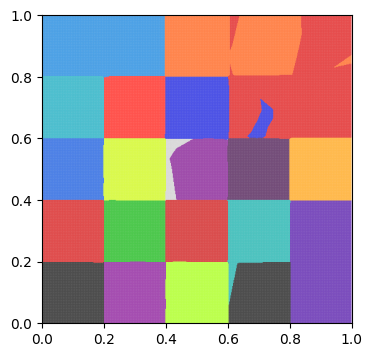

In [8]:
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
x, y = np.meshgrid(np.arange(0, 1, 0.002), np.arange(0, 1, 0.002))
obs = torch.tensor(np.stack([x, y]).reshape((2, -1)).T, dtype=torch.float, device=homer_encoder.device)
emb = homer_encoder.encode(obs)
df_output = pd.DataFrame([(i, *x) for i, x in zip(emb, obs)], columns=['i', 'x', 'y'])
plot_latent_state_color_map(df_output, os.path.join('/tmp/latent_state.png'))

In [9]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.24it/s]


In [10]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-23 21:01:39,206 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [11]:
qbe = QueueEvaluator(
    dataset,
    num_states=25,
    encoder=homer_encoder,
)

## Learn

In [12]:
# true env for online validation
env = gym.make('MyGridNaviCoords-v1', seed=100000)
env.reset_task(np.array([4, 4]))

array([4, 4])

In [13]:
for seed in range(10):
    qbe.reset_sampler(seed=seed)
    spinup.ppo(
        env_fn=lambda: qbe, steps_per_epoch=5000, epochs=50, seed=seed, 
        logger_kwargs=dict(output_dir=f'./outputs/grid_qbe_homer50/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo'), 
        ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
        validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/grid_qbe_homer50/seed=0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7f9057881680>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f905787da10>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/grid_qbe_homer50/seed=0",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/grid_qbe_homer50/seed=0/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
  

## Visualize learning curves

In [14]:
dfs = [pd.read_csv(f'./outputs/grid_qbe_homer50/seed={seed}/progress.txt', sep='\t') for seed in range(10)]

### All runs

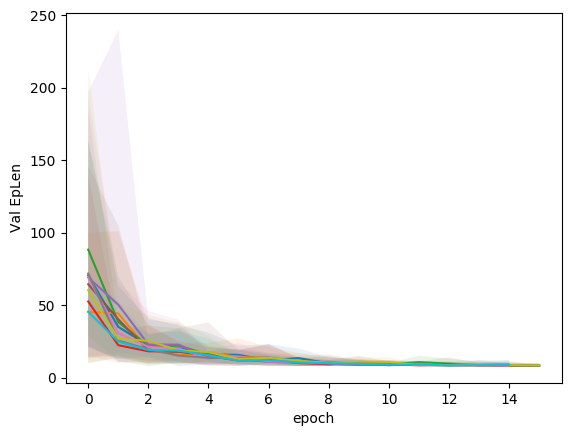

In [15]:
for df in dfs:
    plt.plot(df['AverageVal_EpLen'])
    plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.1)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

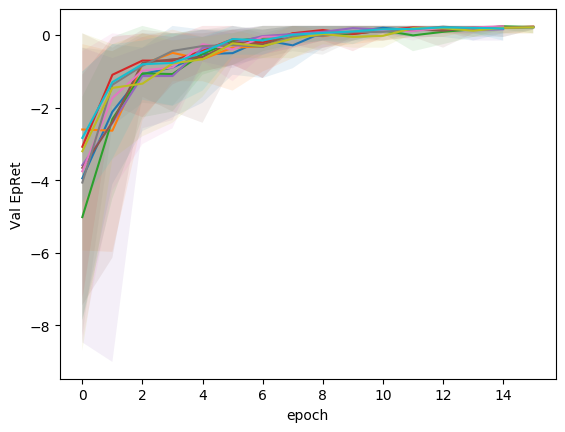

In [16]:
for df in dfs:
    plt.plot(df['AverageVal_EpRet'])
    plt.fill_between(df['Epoch'], df['MinVal_EpRet'], df['MaxVal_EpRet'], alpha=0.1)
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()

### Averaged

In [17]:
df_ = pd.concat(dfs).groupby('Epoch').mean().reset_index()

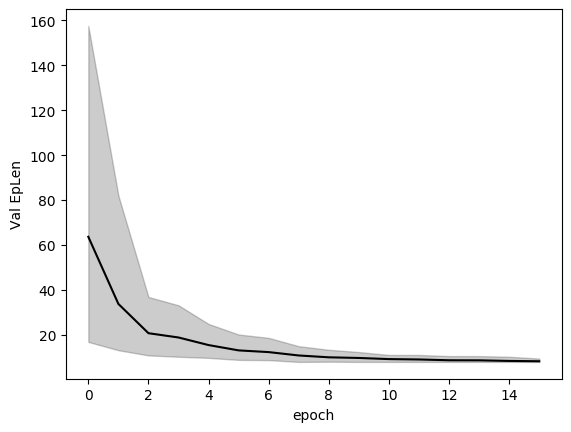

In [18]:
plt.plot(df_['AverageVal_EpLen'], color='k')
plt.fill_between(df_['Epoch'], df_['MinVal_EpLen'], df_['MaxVal_EpLen'], alpha=0.2, color='k')
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

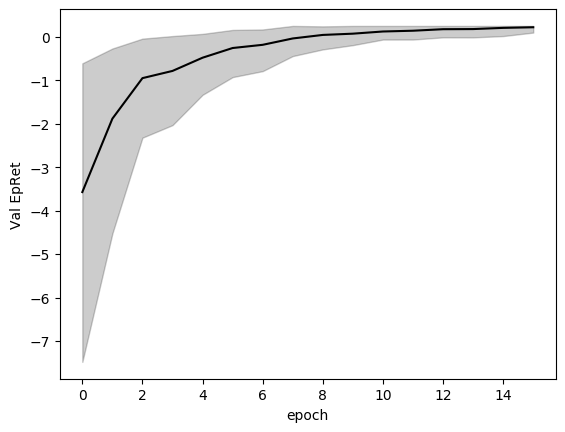

[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 11
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 209
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 39
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 242
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 149
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 29
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 64
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 224
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 168
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 53
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 213
[GCRAZGDL2222:1318692] tcp_peer_recv_connect_ack: invalid header type: 36
Bad pipe message: %s [b"Dz\n\x13\x0f\xacm\xa9\x89\xfc\xf0\xa0K\x82\x9d\x8cI\xaa\x00\x00|\xc0,\xc00\x00\xa3

In [19]:
plt.plot(df_['AverageVal_EpRet'], color='k')
plt.fill_between(df_['Epoch'], df_['MinVal_EpRet'], df_['MaxVal_EpRet'], alpha=0.2, color='k')
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()